# Updating Statistics on the Fly Notebook

## Dependencies

In [1]:
# Start writing code here...
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from NCAA.py import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#from dtreeviz.trees import dtreeviz

### Importing data and introducing a ranked binary variable to see if we can determine better teams with our statistics

In [2]:
df = pd.read_csv('NameStats.csv')
#introducing rankings
ranked_teams_now = ['Kansas Jayhawks', 'Gonzaga Bulldogs', 'Dayton Flyers', 'Florida State Seminoles', 'Baylor Bears', 'San Diego State Aztecs', 'Creighton Bluejays', 'Kentucky Wildcats', 
'Michigan State Spartans', 'Villanova Wildcats', 'Duke Blue Devils', 'Maryland Terrapins', 'Oregon Ducks', 'Louisville Cardinals', 'Seton Hall Pirates', 'Virginia Cavaliers', 'Wisconsin Badgers',
'BYU Cougars', 'Ohio State Buckeyes', 'Auburn Tigers', 'Illinois Fighting Illini', 'Houston Cougars', 'Butler Bulldogs', 'West Virginia Mountaineers', 'Iowa Hawkeyes'
]
df['RANKED_FINAL'] = 0
for team in ranked_teams_now:
    df.loc[df['TeamName']==team, 'RANKED_FINAL']=1
df.head()

,Unnamed: 0,TeamName,Team ID,WinPct,RPI,OWP,OOWP,SOS,KRACH,RANKED_FINAL
0,0,Florida Gulf Coast Eagles,526,0.312500,0.429082,0.489588,0.470484,50.829595,15.518772,0
1,1,Jacksonville Dolphins,294,0.437500,0.449006,0.458933,0.478157,43.240693,26.904202,0
2,2,Kennesaw State Owls,338,0.034483,0.383427,0.514614,0.469998,65.360691,2.590737,0
3,3,Liberty Flames,2335,0.882353,0.561022,0.441171,0.486745,31.771002,315.304534,0
4,4,Lipscomb Bisons,288,0.500000,0.482695,0.488445,0.487222,46.157922,34.141672,0


## Explratory Data Analysis for Problem 1: Can we seperate teams based on skill?


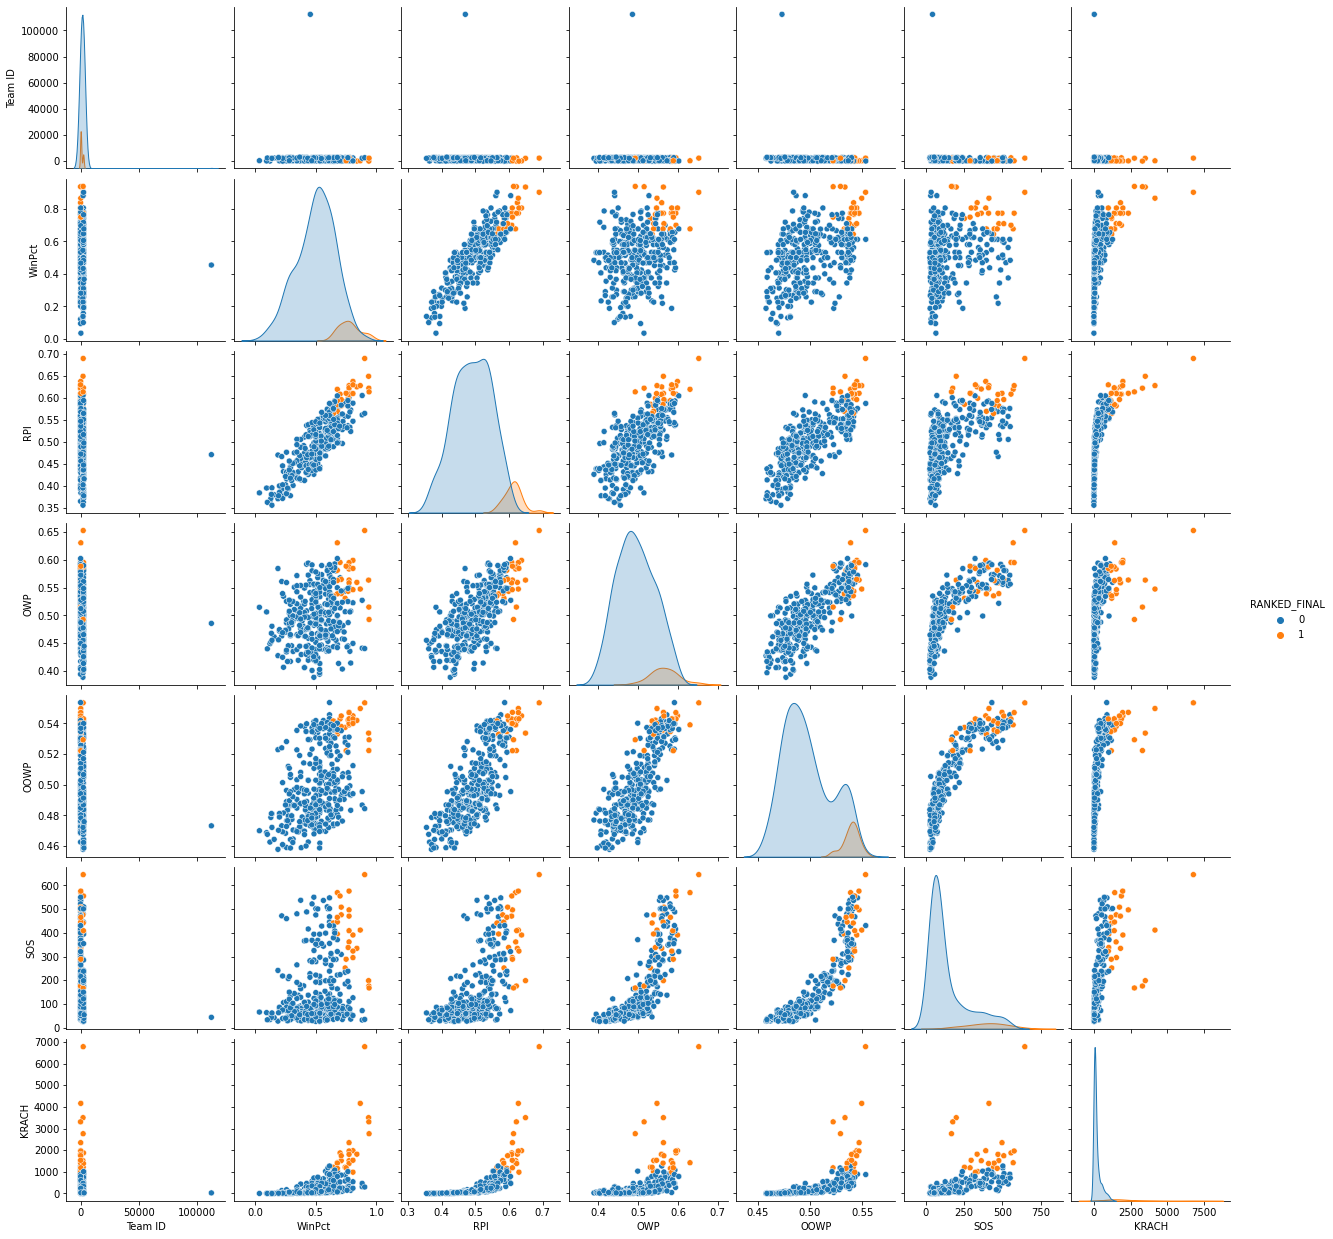

In [3]:
sns.pairplot(data=df.drop('TeamName', axis=1).drop('Unnamed: 0', axis=1), hue='RANKED_FINAL')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


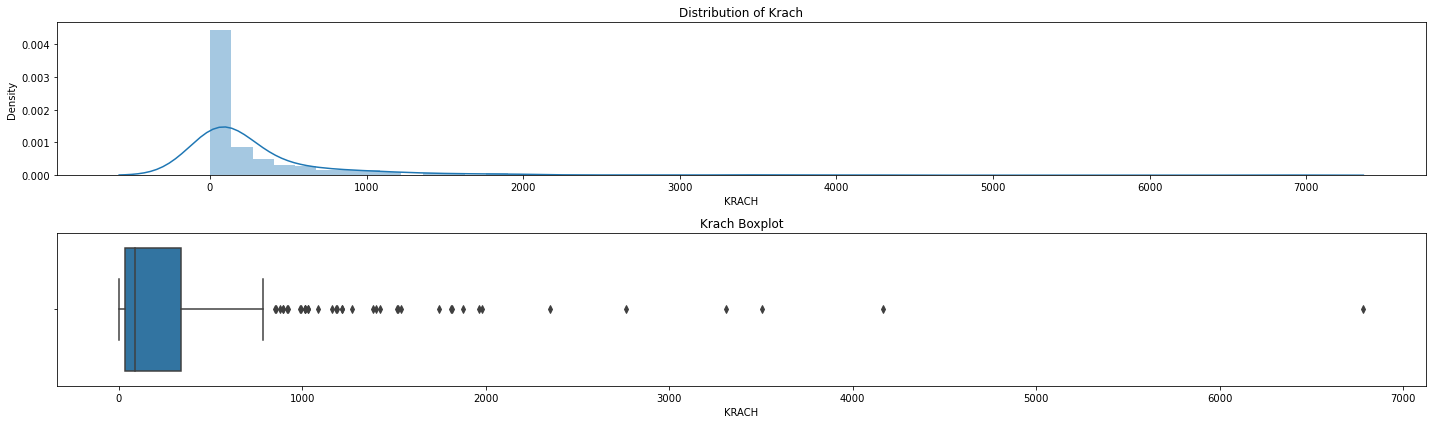

In [4]:
 #There are a lot of outliers in the krach data
 fig, ax = plt.subplots(2,1, figsize=(20, 6))
 sns.distplot(df['KRACH'], ax=ax[0])
 ax[0].set(title='Distribution of Krach')
 sns.boxplot(df['KRACH'], ax=ax[1])
 ax[1].set(title='Krach Boxplot')
 plt.tight_layout()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


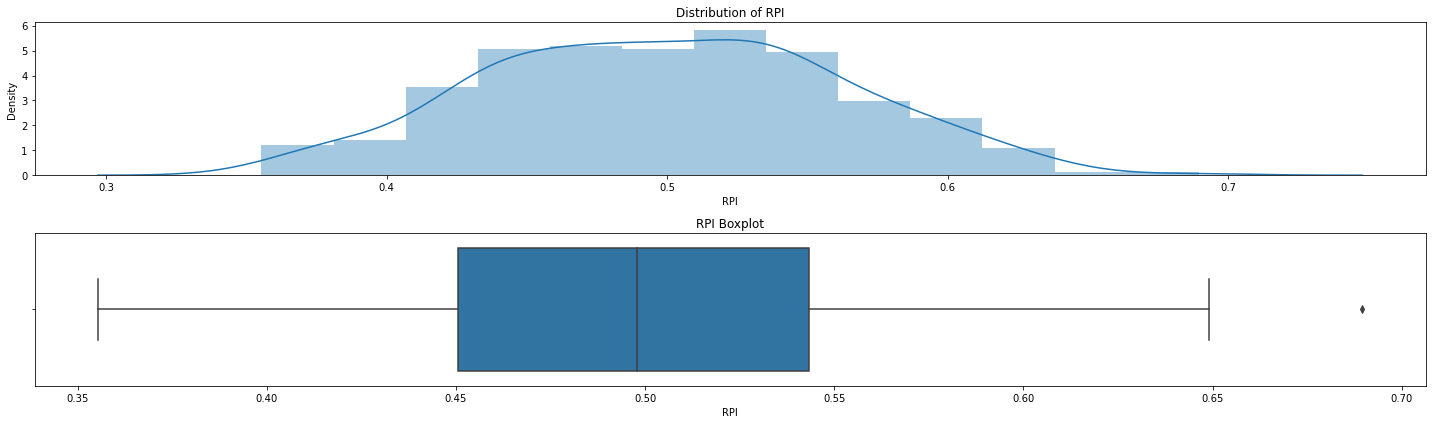

In [5]:
 #There are a lot of outliers in the krach data
 fig, ax = plt.subplots(2,1, figsize=(20, 6))
 sns.distplot(df['RPI'], ax=ax[0])
 ax[0].set(title='Distribution of RPI')
 sns.boxplot(df['RPI'], ax=ax[1])
 ax[1].set(title='RPI Boxplot')
 plt.tight_layout()

**Between the KRACH and RPI distributions, it looks like there are more KRACH outliers. This probably seperates a lot of ranked or better teams from unranked or worse ones.**

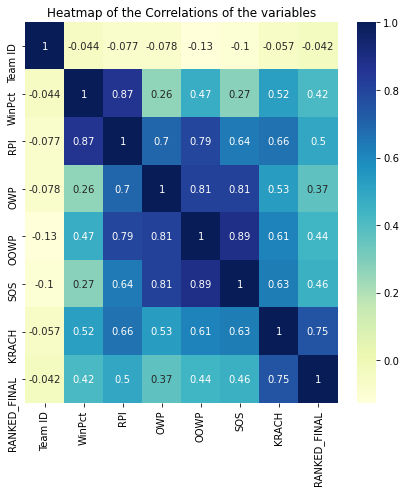

In [6]:
plt.figure(figsize=(7,7))
plt.title('Heatmap of the Correlations of the variables')
sns.heatmap(df.drop('TeamName', axis=1).drop('Unnamed: 0', axis=1).corr(), annot=True, cmap="YlGnBu")

**KRACH and RPI seem to be two of the best predictors to determine if a team is ranked or not.**

Text(0.5, 1.0, 'Can we find a decision boundary using KRACH and RPI?')

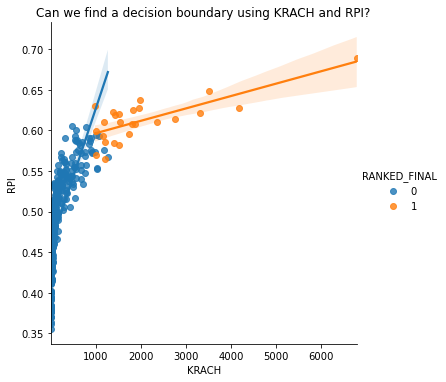

In [7]:
sns.lmplot(y='RPI', x='KRACH', data=df, hue='RANKED_FINAL')
plt.title('Can we find a decision boundary using KRACH and RPI?')

**It does look like there exists a decision boundary between better (ranked) teams using KRACH and RPI.**

## Baseline Modeling for Problem 1

### Splitting the data

In [8]:
#fitting some baseline models
random_state = 144
X=df.drop(['Unnamed: 0', 'TeamName'], axis=1)
y=df['RANKED_FINAL']
X_train, X_val, y_train,y_val = train_test_split(X,y,
                                train_size = 0.8,
                                random_state =random_state)

### Fitting a simple random forest tree with a low max depth

In [9]:
dtree2 = RandomForestClassifier(max_depth=2).fit(X_train[['KRACH', 'RPI']],y_train)
y_pred = dtree2.predict(X_val[['KRACH', 'RPI']])
print('For this baseline random forest, the accuracy is: ', accuracy_score(y_pred, y_val))

For this baseline random forest, the accuracy is:  0.971830985915493


### Understanding our baseline model

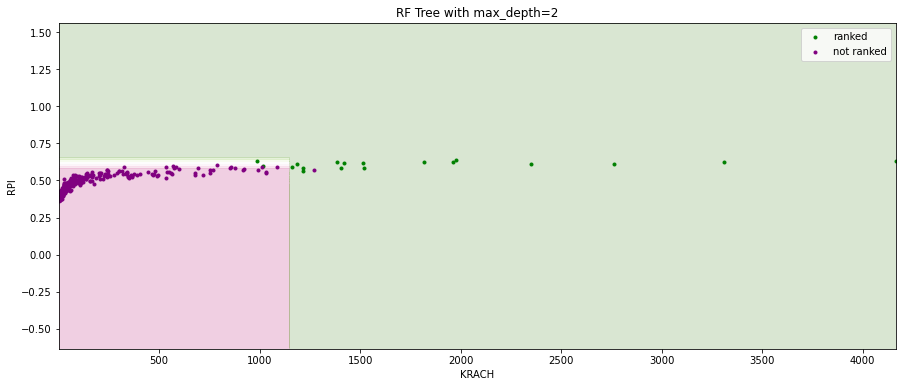

In [10]:
x1_min, x1_max = X_train['KRACH'].min() - 1, X_train['KRACH'].max() + 1
x2_min, x2_max = X_train['RPI'].min() - 1, X_train['RPI'].max() + 1

x1x, x2x = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                     np.arange(x2_min, x2_max, 0.1))


yhat2 = dtree2.predict(np.c_[x1x.ravel(), x2x.ravel()]).reshape(x1x.shape)
fig, (ax1) = plt.subplots(1,1, figsize=[15,6])

ax1.contourf(x1x, x2x, yhat2, alpha=0.2,cmap="PiYG");
ax1.scatter(X_train['KRACH'][y_train==1], X_train['RPI'][y_train==1],marker=".",color="green",label='ranked')
ax1.scatter(X_train['KRACH'][y_train==0], X_train['RPI'][y_train==0],marker=".",color="purple",label="not ranked")

ax1.set_xlabel("KRACH")
ax1.set_ylabel("RPI")
ax1.set_title("RF Tree with max_depth=2")
ax1.legend()

**It looks like the random forest can determine ranked teams from unranked teams with high accuracy**

Text(0, 0.5, 'True Positive Rate')

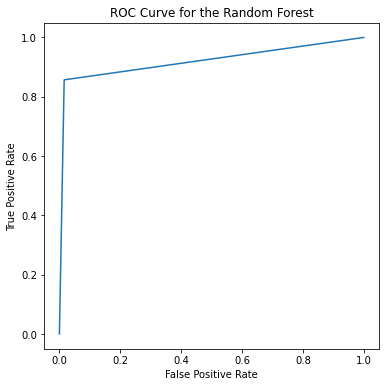

In [11]:
#we have an imbalanced data set, so we can check ROC
y_pred=dtree2.predict(X_val[['KRACH', 'RPI']])

plt.figure(figsize=(6, 6))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.plot(fpr,tpr,label="roc")
plt.title('ROC Curve for the Random Forest')
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')


**Because we have an imbalanced dataset, we check an ROC curve, which indicates that there is room for improvement in seperating good vs bad teams.**

## Problem 2: Can we predict changing offensive and defensive efficiencies after each game?

### Problem 2 data importation and preprocessing

In [12]:
total_df = pd.read_csv('prev_and_new_rtgs.csv')
total_df.head()

,Game ID,Home Team ID,Away Team ID,Home Team Score,Away Team Score,Home Team # Previous Games,Home Team Previous ORtg,Home Team Previous DRtg,Away Team # Previous Games,Away Team Previous ORtg,Away Team Previous DRtg,Home Team New ORtg,Home Team New DRtg,Away Team New ORtg,Away Team New DRtg
0,401170101,139,526,89,67,0,0.000000,0.000000,0,0.000000,0.000000,136.171703,102.511282,102.511282,136.171703
1,401170347,526,2378,61,65,1,102.511282,136.171703,0,0.000000,0.000000,96.645493,116.452087,96.732471,90.779703
2,401170353,159,526,55,49,1,93.490476,86.616177,2,96.645493,116.452087,88.314760,80.342753,89.120105,92.143343
3,401170359,2382,526,84,68,2,96.897381,107.641931,3,89.120105,105.347739,101.302169,101.473980,89.124599,94.368015
4,401170371,526,2226,72,70,4,89.124599,106.538741,2,85.140213,108.612139,90.019847,103.431156,87.093748,87.960422


**We use the non-ID features to predict new offensive efficiency and new defensive efficiencies in a regression problem.**

### Looking at some simple model statistics

In [13]:
total_df.describe()

,Game ID,Home Team ID,Away Team ID,Home Team Score,Away Team Score,Home Team # Previous Games,Home Team Previous ORtg,Home Team Previous DRtg,Away Team # Previous Games,Away Team Previous ORtg,Away Team Previous DRtg,Home Team New ORtg,Home Team New DRtg,Away Team New ORtg,Away Team New DRtg
count,5.329000e+03,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000
mean,4.011733e+08,1567.331582,1813.112029,72.786451,67.608369,14.669919,98.919915,97.509080,14.608369,97.188479,98.764040,102.789337,100.198205,100.120177,101.685183
std,8.186464e+03,5595.981617,6708.911410,11.945800,11.571488,8.748406,19.762255,19.630480,8.819274,20.227930,20.452363,8.233722,8.615343,8.573262,7.731719
min,4.011660e+08,2.000000,2.000000,34.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.687810,52.190247,52.190247,58.687810
25%,4.011698e+08,166.000000,201.000000,64.000000,60.000000,7.000000,96.726736,95.133130,7.000000,95.268205,96.382366,97.890554,95.322144,95.587005,97.073479
50%,4.011719e+08,2000.000000,2086.000000,72.000000,67.000000,15.000000,102.042358,100.652115,15.000000,100.837099,101.789890,102.788114,100.642142,100.790295,101.839856
75%,4.011748e+08,2440.000000,2460.000000,80.000000,75.000000,22.000000,107.234832,105.503282,22.000000,106.111491,106.946948,107.819303,105.357996,105.933009,106.634763
max,4.012121e+08,112358.000000,112358.000000,143.000000,116.000000,32.000000,145.679354,143.885333,33.000000,138.909737,147.570912,145.679354,131.851210,132.618578,147.570912


In [14]:
homeWon = 1*(total_df['Home Team Score'] > total_df['Away Team Score'])
awayWon = 1-homeWon
didWin = list(homeWon) + list(awayWon)

In [15]:
team_ids_arr = list(total_df['Home Team ID']) + list(total_df['Away Team ID'])
game_ids_arr = list(total_df['Game ID']) + list(total_df['Game ID'])
team_self_score_arr = list(total_df['Home Team Score']) + list(total_df['Away Team Score'])
team_opp_score_arr = list(total_df['Away Team Score']) + list(total_df['Home Team Score'])
team_prevgames_arr = list(total_df['Home Team # Previous Games']) + list(total_df['Away Team # Previous Games'])
team_prev_ortg_arr = list(total_df['Home Team Previous ORtg']) + list(total_df['Away Team Previous ORtg'])
team_prev_drtg_arr = list(total_df['Home Team Previous DRtg']) + list(total_df['Away Team Previous DRtg'])
team_new_ortg_arr = list(total_df['Home Team New ORtg']) + list(total_df['Away Team New ORtg'])
team_new_drtg_arr = list(total_df['Home Team New DRtg']) + list(total_df['Away Team New DRtg'])
is_home_arr = list(np.ones(5329)) + list(np.zeros(5329))

In [16]:
games_df = pd.DataFrame([team_ids_arr, game_ids_arr, is_home_arr, didWin, team_self_score_arr, team_opp_score_arr, team_prevgames_arr, team_prev_ortg_arr, team_prev_drtg_arr, team_new_ortg_arr, team_new_drtg_arr]).transpose()
games_df.columns = ['Team ID', 'Game ID', 'isHome', 'didWin', 'Self Team Score', 'Opp Team Score', 'Prev Games', 'Prev ORtg', 'Prev DRtg', 'New ORtg', 'New DRtg']
games_df.head()

,Team ID,Game ID,isHome,didWin,Self Team Score,Opp Team Score,Prev Games,Prev ORtg,Prev DRtg,New ORtg,New DRtg
0,139.0,401170101.0,1.0,1.0,89.0,67.0,0.0,0.000000,0.000000,136.171703,102.511282
1,526.0,401170347.0,1.0,0.0,61.0,65.0,1.0,102.511282,136.171703,96.645493,116.452087
2,159.0,401170353.0,1.0,1.0,55.0,49.0,1.0,93.490476,86.616177,88.314760,80.342753
3,2382.0,401170359.0,1.0,1.0,84.0,68.0,2.0,96.897381,107.641931,101.302169,101.473980
4,526.0,401170371.0,1.0,1.0,72.0,70.0,4.0,89.124599,106.538741,90.019847,103.431156


### Including the advanced metrics

In [17]:
namestats_df = df
games_df['WinPct'] = 0
games_df['RPI'] = 0
games_df['OWP'] = 0
games_df['OOWP'] = 0
games_df['SOS'] = 0
games_df['KRACH'] = 0
for teamid in namestats_df['Team ID']:
    krach = int(namestats_df.loc[namestats_df['Team ID'] == teamid]['KRACH'].values)
    winpct = float(namestats_df.loc[namestats_df['Team ID'] == teamid]['WinPct'].values)
    rpi = float(namestats_df.loc[namestats_df['Team ID'] == teamid]['RPI'].values)
    owp = float(namestats_df.loc[namestats_df['Team ID'] == teamid]['OWP'].values)
    oowp = float(namestats_df.loc[namestats_df['Team ID'] == teamid]['OOWP'].values)
    sos = float(namestats_df.loc[namestats_df['Team ID'] == teamid]['SOS'].values)
    #games_df.loc[games_df['Team ID']==teamid]['KRACH'] = krach
    games_df.loc[games_df['Team ID']==teamid, 'KRACH'] = krach
    games_df.loc[games_df['Team ID']==teamid, 'WinPct'] = winpct
    games_df.loc[games_df['Team ID']==teamid, 'RPI'] = rpi
    games_df.loc[games_df['Team ID']==teamid, 'OWP'] = owp
    games_df.loc[games_df['Team ID']==teamid, 'OOWP'] = oowp
    games_df.loc[games_df['Team ID']==teamid, 'SOS'] = sos
    
    
games_df.head()
    

,Team ID,Game ID,isHome,didWin,Self Team Score,Opp Team Score,Prev Games,Prev ORtg,Prev DRtg,New ORtg,New DRtg,WinPct,RPI,OWP,OOWP,SOS,KRACH
0,139.0,401170101.0,1.0,1.0,89.0,67.0,0.0,0.000000,0.000000,136.171703,102.511282,0.741935,0.586980,0.543518,0.527552,184.270973,574
1,526.0,401170347.0,1.0,0.0,61.0,65.0,1.0,102.511282,136.171703,96.645493,116.452087,0.312500,0.429082,0.489588,0.470484,50.829595,15
2,159.0,401170353.0,1.0,1.0,55.0,49.0,1.0,93.490476,86.616177,88.314760,80.342753,0.413793,0.456356,0.474474,0.483620,67.671342,49
3,2382.0,401170359.0,1.0,1.0,84.0,68.0,2.0,96.897381,107.641931,101.302169,101.473980,0.531250,0.469101,0.439746,0.496912,65.368029,61
4,526.0,401170371.0,1.0,1.0,72.0,70.0,4.0,89.124599,106.538741,90.019847,103.431156,0.312500,0.429082,0.489588,0.470484,50.829595,15


### Quick EDA: how do offensive and defensive efficiency change over the season?

In [18]:
from NCAA import *
teams, games = recalldata('teamsgames.pkl')
a = sorted(teams[108].games, key=lambda i: i.time)
b = [i.offensiveratings()[108] for i in a]

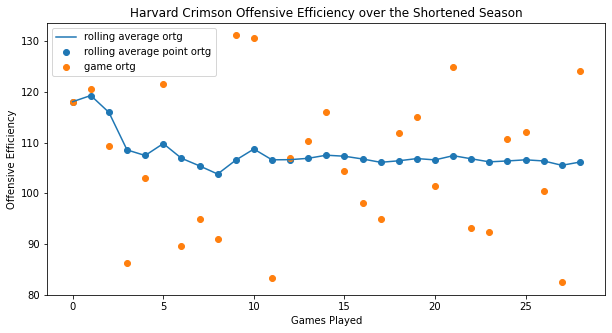

In [19]:
rolling_avgs = np.cumsum(b)/np.linspace(1, len(b), len(b))
plt.figure(figsize=(10, 5))
plt.title('Harvard Crimson Offensive Efficiency over the Shortened Season')
plt.xlabel('Games Played')
plt.ylabel('Offensive Efficiency')
plt.plot(range(len(rolling_avgs)), rolling_avgs, label='rolling average ortg')
plt.scatter(range(len(rolling_avgs)), rolling_avgs, label='rolling average point ortg')
plt.scatter(range(len(rolling_avgs)), b, label='game ortg')
plt.legend()

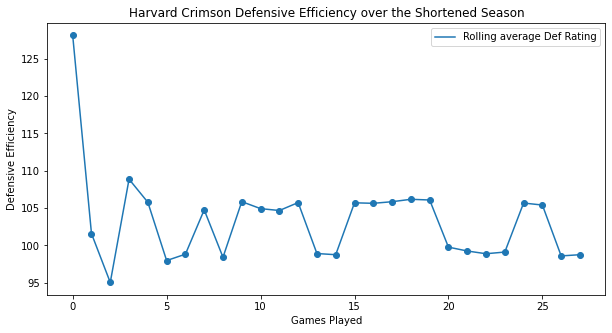

In [28]:
plt.figure(figsize=(10, 5))
harvardDrtg = games_df[games_df['Team ID']==108].sort_values(by='Prev Games')['New DRtg']
plt.plot(range(len(harvardDrtg)), harvardDrtg, label='Rolling average Def Rating')
plt.scatter(range(len(harvardDrtg)), harvardDrtg)

plt.title('Harvard Crimson Defensive Efficiency over the Shortened Season')
plt.xlabel('Games Played')
plt.ylabel('Defensive Efficiency')
#plt.plot(range(len(rolling_avgs)), rolling_avgs, label='rolling average ortg')
#plt.scatter(range(len(rolling_avgs)), rolling_avgs, label='rolling average point ortg')
#plt.scatter(range(len(rolling_avgs)), b, label='game ortg', color='red')
plt.legend()

**These images reflect the changing values in efficiencies for the Harvard Crimson basketball team. Clearly, as the season progresses, these values are subject to change.**

### Splitting the data for the offensive and defensive model

In [20]:
Offensive_X = games_df.drop(['Team ID', 'Game ID', 'New ORtg', 'New DRtg'], axis=1)
Offensive_y = games_df['New ORtg']

In [21]:
print(f"Model inputs: {Offensive_X.columns}")

Model inputs: Index(['isHome', 'didWin', 'Self Team Score', 'Opp Team Score', 'Prev Games',
       'Prev ORtg', 'Prev DRtg', 'WinPct', 'RPI', 'OWP', 'OOWP', 'SOS',
       'KRACH'],
      dtype='object')


In [22]:
Defensive_X = games_df.drop(['Team ID', 'Game ID', 'New ORtg', 'New DRtg'], axis=1)
Defensive_y = games_df['New DRtg']

## Offensive Efficiency Modeling

### Baseline Modeling with a low max depth: Is this a reasonable problem?

In [23]:
X_train, X_test, y_train, y_test = train_test_split(Offensive_X, Offensive_y, random_state=2020, test_size=.25)

In [24]:
abs_error = []
sq_error = []
out_of_bag = []

for depth in range(1, 20):
    tree = RandomForestRegressor(max_depth = depth,oob_score=True).fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mse = mean_squared_error(y_pred, y_test)
    
    abs_error.append(mae)
    sq_error.append(mse)
    out_of_bag.append(tree.oob_score_)
    

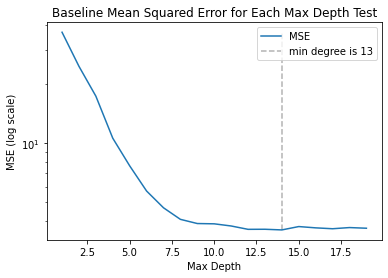

The best baseline MSE is  3.6033


In [25]:
#the mse graph
plt.title('Baseline Mean Squared Error for Each Max Depth Test')
plt.semilogy(list(range(1,20)), sq_error, label='MSE')
plt.vlines(x=np.argmin(sq_error)+1, ymin=np.min(sq_error), ymax=np.max(sq_error), alpha=.3, linestyles='dashed', label='min degree is ' + str(np.argmin(sq_error)))
plt.xlabel('Max Depth')
plt.ylabel('MSE (log scale)')
plt.legend()
plt.show()
print(f'The best baseline MSE is {np.min(sq_error): .4f}')

## Hyperparameter tuning the offensive model with a random search

In [26]:
#fit a hyperparameter tuner
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
rf = RandomForestRegressor(random_state=2020)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2020,
 'verbose': 0,
 'warm_start': False}


In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(6, 30, num = 24)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               30,
               None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 290, 480, 670, 860, 1050, 1240, 1430, 1620, 1810, 2000]}


In [96]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False, total=  17.5s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False, total=  18.0s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=False, total=  18.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.9s finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [6, 7, 8, 9, 10, 11, 12,
                                                      13, 14, 15, 16, 17, 18,
                                                      19, 20, 21, 22, 23, 24,
                                                      25, 26, 27, 28, 30,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 290, 480, 670,
                                                         860, 1050, 1240, 1430,
                                                         1620, 1810, 2000]},
                   random_state=42, verbo

### Analyzing the random search's best offensive model

In [97]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 17,
 'bootstrap': False}

In [98]:
best_model = rf_random.best_estimator_

In [99]:
y_best_pred = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, y_best_pred)
best_r2 = r2_score(y_test, y_best_pred)
print('The MSE on the best model is ', best_mse)
print('The R^2 is ', best_r2)

The MSE on the best model is  5.059984138512915
The R^2 is  0.9300974777328245


In [100]:
variance_y = np.var(Offensive_y)
print('The MSE as a percentage of variance is ', 100*best_mse/variance_y)

The MSE as a percentage of variance is  6.9874470526237245


Text(0.5, 1.0, 'Relative Variable Importance for best offensive model')

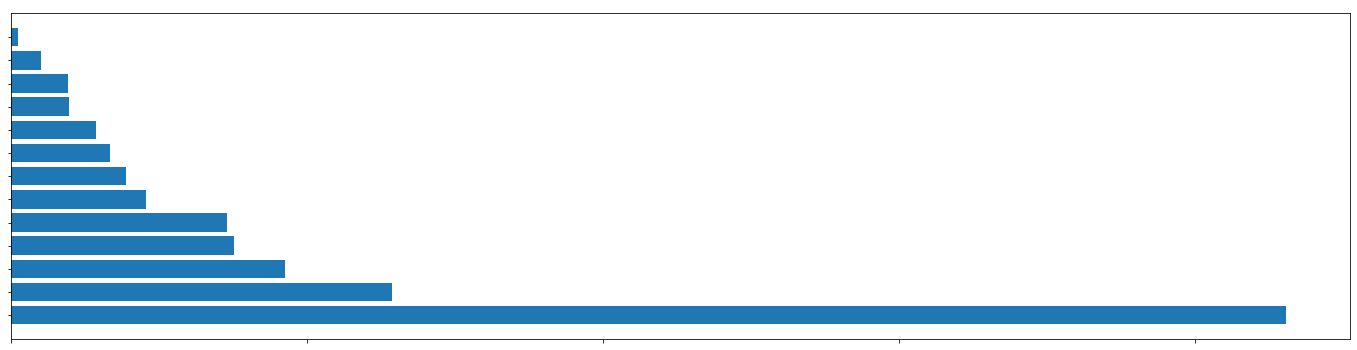

In [101]:
#do permutation importance and feature importance
plt.figure(figsize=(24, 6))

num = len(X_train.columns)

best_importances = best_model.feature_importances_
order = np.flip(np.argsort(best_importances))[0:num]
plt.barh(range(num),best_importances[order],tick_label=Offensive_X.columns[order]);
plt.title("Relative Variable Importance for best offensive model")

In [ ]:
#run this only when the entire randomsearch happens
dump(best_model, 'bestrfregress.joblib') 

## Defensive Efficiency modeling

### Doing the same hyperparameter tuning for a defensive model

In [29]:
X_train, X_test, y_train, y_test = train_test_split(Defensive_X, Defensive_y, random_state=2020, test_size=.25)

In [30]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2020,
 'verbose': 0,
 'warm_start': False}


In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(6, 130, num = 90)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               #'warm_start': True,
               #'oob_score': True
               }
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [6,
               7,
               8,
               10,
               11,
               12,
               14,
               15,
               17,
               18,
               19,
               21,
               22,
               24,
               25,
               26,
               28,
               29,
               31,
               32,
               33,
               35,
               36,
               38,
               39,
               40,
               42,
               43,
               45,
               46,
               47,
               49,
               50,
               51,
               53,
               54,
               56,
               57,
               58,
               60,
               61,
               63,
               64,
               65,
               67,
               68,
               70,
               71,
               72,
               74,
               75,
     

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=4, random_state=2020, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

### Defensive model analysis

In [38]:
best_model_2 = rf_random.best_estimator_
new_def_pred = best_model_2.predict(X_test)
print('R2: ', r2_score(y_test, new_def_pred))
print('MSE: ', mean_squared_error(y_test, new_def_pred))
variance_y = np.var(Defensive_y)
print('The MSE as a percentage of variance is ', 100*mean_squared_error(y_test, new_def_pred)/variance_y)


In [34]:
#do permutation importance and feature importance
plt.figure(figsize=(24, 6))

num = len(X_train.columns)

best_importances = best_model_2.feature_importances_
order = np.flip(np.argsort(best_importances))[0:num]
plt.barh(range(num),best_importances[order],tick_label=Defensive_X.columns[order]);
plt.title("Relative Variable Importance for best defensive model")

In [ ]:
dump(best_model_2, 'defensiveregress.joblib')

**end of notebook. included offensive and defensive efficiency models.**